## Домашнее задание по теме «Элементарные методы анализа временных рядов»

### **Задание**

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [4]:
none_stationary_series = dowjones_closing.Close

stationary_series = boxcox(dowjones_closing.Close, 0)
stationary_series = np.diff(stationary_series, 1)

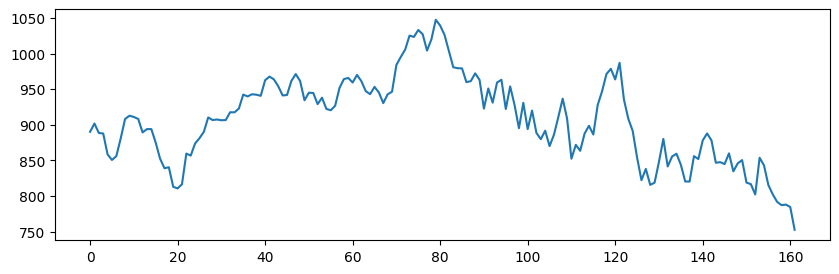

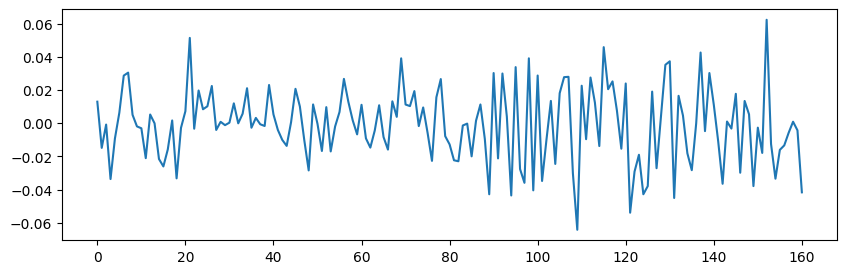

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(none_stationary_series)
plt.show()
plt.figure(figsize=(10, 3))
plt.plot(stationary_series)
plt.show()

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [7]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

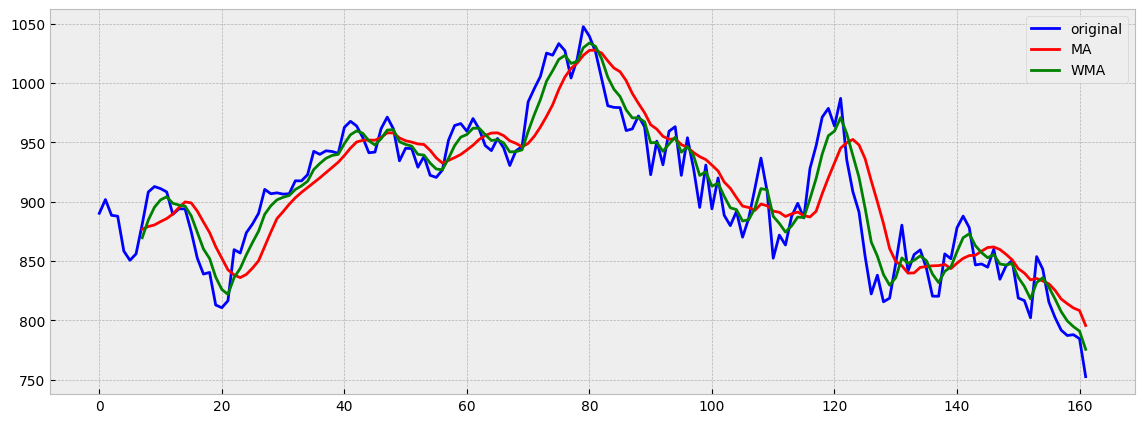

In [8]:
wma = weighted_moving_average(none_stationary_series, 8, [1,1,2,3,5,8,13,21])
ma = moving_average(none_stationary_series, 8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    plt.plot(none_stationary_series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

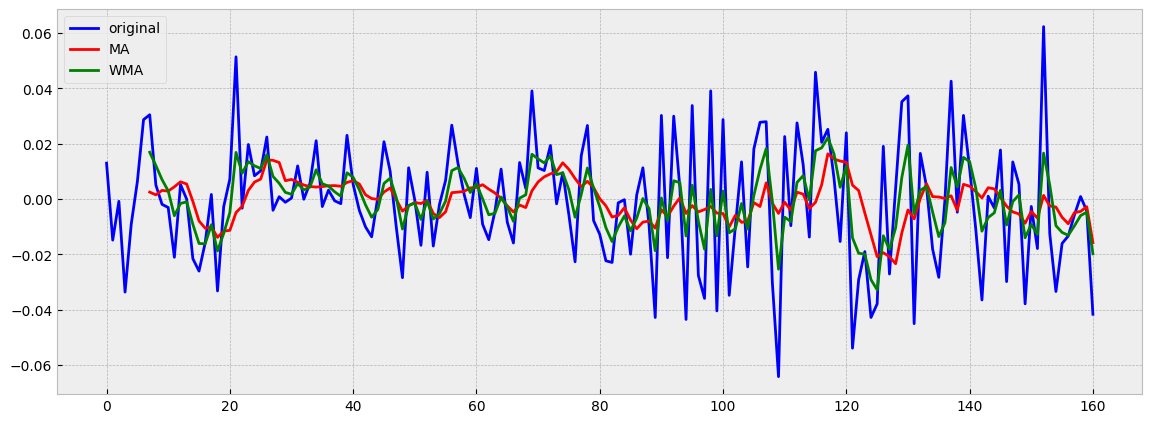

In [9]:
wma = weighted_moving_average(stationary_series, 8, [1,1,2,3,5,8,13,21])
ma = moving_average(stationary_series, 8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    plt.plot(stationary_series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

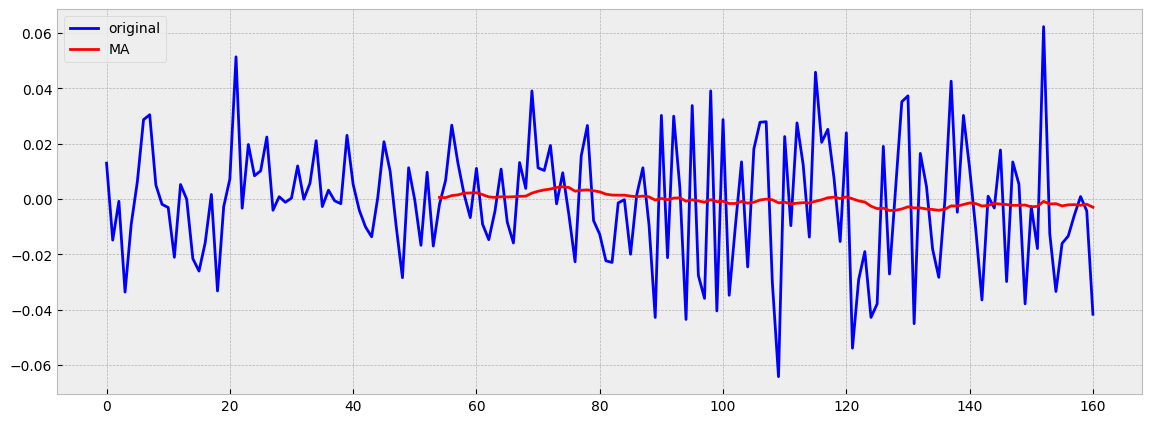

In [10]:
ma = moving_average(stationary_series, 55)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 5))
    plt.plot(stationary_series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.legend()

### Попробуем для начальной серии подобрать наиболее оптимальный период сглаживания для ma

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
def mse(n, series):
    result = moving_average(series, n)
    err = mean_squared_error(result[n-1:], series[n-1:])
    return err

In [13]:
print(mse(5, none_stationary_series))

462.4100689113929


In [14]:
error = []
for i in range(2, 21):
    error.append(mse(i, none_stationary_series))

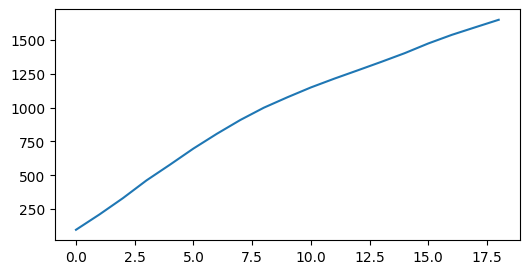

In [15]:
plt.figure(figsize = (6, 3)) 
pd.Series(error).plot()
plt.show()

### **Вывод:** Moving Average ухудшает точность с ростом периода сглаживания

In [16]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

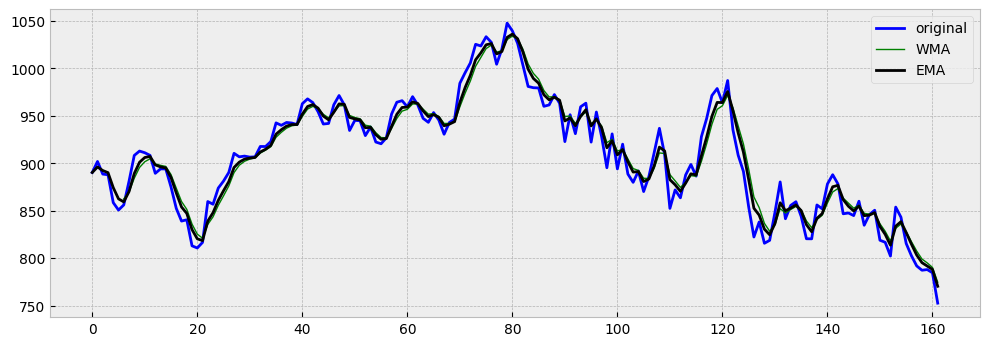

In [17]:
ema = exponential_moving_average(none_stationary_series, 0.5)
wma = weighted_moving_average(none_stationary_series, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(none_stationary_series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

In [18]:
print(f'MSE for EMA with alpha = 0.5 is equal to {mean_squared_error(ema, none_stationary_series):.2f}')
print(f'MSE for WMA with period 7 and Fib weights is equal to {mean_squared_error(wma[6:], none_stationary_series[6:]):.2f}')

MSE for EMA with alpha = 0.5 is equal to 124.76
MSE for WMA with period 7 and Fib weights is equal to 214.57


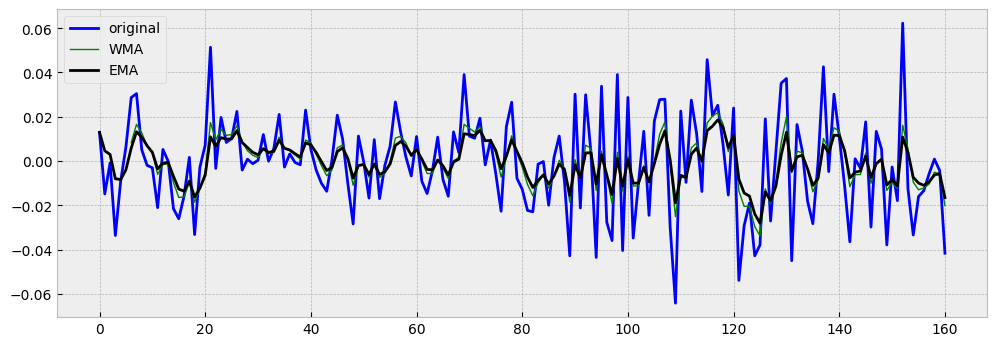

In [19]:
ema = exponential_moving_average(stationary_series, 0.3)
wma = weighted_moving_average(stationary_series, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 4))
    plt.plot(stationary_series, color='blue',label='original')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

In [20]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [21]:
def plot_dema(alpha, beta, series):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        print(f'MSE for DEMA with alpha = {alpha}, beta = {beta} is equal to {mean_squared_error(series, dema):.2f}')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

MSE for DEMA with alpha = 0.8, beta = 0.2 is equal to 38.50


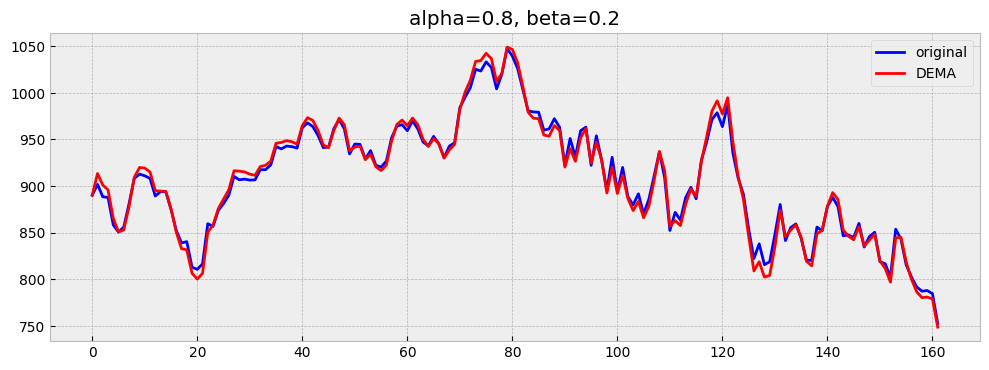

In [22]:
plot_dema(0.8, 0.2, none_stationary_series)

In [23]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [24]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [25]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [26]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        print(f'MSE for TEMA with alpha = {alpha}, beta = {beta}, gamma = {gamma} is equal to {mean_squared_error(ser_to_plot, tema[:162]):.2f}')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

MSE for TEMA with alpha = 0.7, beta = 0.2, gamma = 0.3 is equal to 35.56


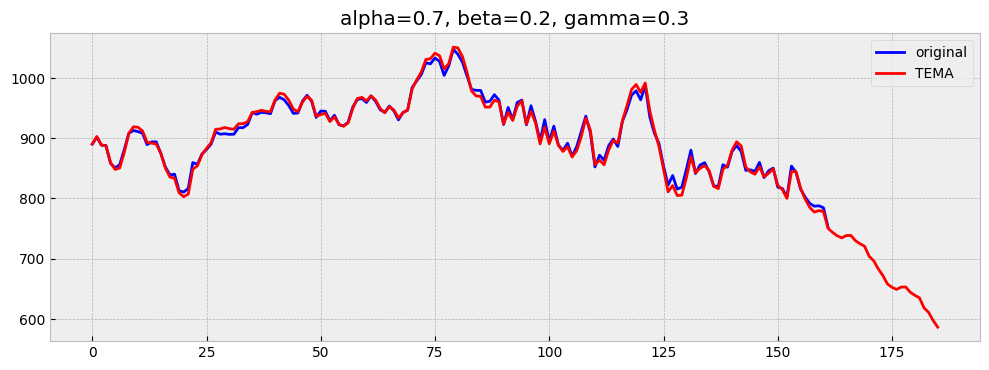

In [27]:
plot_tema(0.7, 0.2, 0.3, none_stationary_series, none_stationary_series)

### **Выводы:**  
1. Поскольку выбранная начальная серия не содержала сезонность и циклы, то она приводилась к стационарному применению преобразований Бокса-Кокса и дифференцированию.
2. Визуально лучшие результаты показали с точки зрения точности MSE методы DEMA и TEMA, но здесь необходимо точно подбирать alpha, beta, gamma.
3. Для стационарного ряда хорошо себя показывает сглаживание при помощи MA с большим периодом, которое позволяет убрать шум.
4. Дополнительно, было посчитано как влияет на точность приближения увеличение числа периодов при сглаживании MA. Как можно было предположить, это будет ухудшать точность.